# Analysis of one-year trace of gut microbiome
This notebook records the code used for analyzing data from [Gibbons _et. al._ (2017)](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005364). 

## Load required packages

In [2]:
## https://gist.github.com/stevenworthington/3178163
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c("ggplot2", "foreach",'doMC','lokern', 'pspline', 'monomvn', 
              "reshape2", "RColorBrewer", "grid", "RCurl", "igraph", "ggsci")
ipak(packages)

Loading required package: ggplot2
Loading required package: foreach
Loading required package: doMC
Loading required package: iterators
Loading required package: parallel
Loading required package: lokern
Loading required package: pspline
Loading required package: monomvn
Loading required package: pls

Attaching package: ‘pls’

The following object is masked from ‘package:stats’:

    loadings

Loading required package: lars
Loaded lars 1.2

Loading required package: MASS
Loading required package: reshape2
Loading required package: RColorBrewer
Loading required package: grid
Loading required package: RCurl
Loading required package: bitops
Loading required package: igraph
Warning message:
“package ‘igraph’ was built under R version 3.4.1”
Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: ggsci
Warning message:
“package ‘ggsci’ was built unde

ggplot2      foreach         doMC       lokern      pspline      monomvn 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
    reshape2 RColorBrewer         grid        RCurl       igraph        ggsci 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE

## Access Dropbox files

In [3]:
source.dropbox = function(dropbox.url, targetFile) {
    ### Adapted from http://rstudio-pubs-static.s3.amazonaws.com/10162_c939e11b01c54cc9afda69b4dd0c62fe.html
    library(RCurl)
    setwd(tempdir())
    destfile = targetFile
    # use regex to get the piece of the Dropbox URL we need
    matches <- regexpr("(/s/.*)", dropbox.url, perl = TRUE, ignore.case = TRUE)
    result <- attr(matches, "capture.start")[, 1]
    attr(result, "match.length") <- attr(matches, "capture.length")[, 1]
    dropbox.tail = regmatches(dropbox.url, result)
    dburl = paste("https://dl.dropbox.com", dropbox.tail, sep = "")
    x = getBinaryURL(dburl, followlocation = TRUE, ssl.verifypeer = FALSE)
    writeBin(x, destfile, useBytes = TRUE)
}

## Download data
If you have downloaded the entire git repository, you can skip this step.

In [4]:
## functions
source.dropbox("https://www.dropbox.com/s/1r8yaidrp5vjjo0/emFunctions.r", "~/beem/emFunctions.r")

## DA
source.dropbox("https://www.dropbox.com/s/oa47p5ru9846ss7/DA.counts.txt", "~/beem/time_series_analysis/DA.counts.txt")
source.dropbox("https://www.dropbox.com/s/kq0nd849osoyavh/DA.metadata.txt", "~/beem/time_series_analysis/DA.metadata.txt")
## M3
source.dropbox("https://www.dropbox.com/s/34p46fs2wli3okh/M3.counts.txt", "~/beem/time_series_analysis/M3.counts.txt")
source.dropbox("https://www.dropbox.com/s/02gkmlbsrhjtb14/M3.metadata.txt", "~/beem/time_series_analysis/M3.metadata.txt")
## DB
source.dropbox("https://www.dropbox.com/s/mw9igdeq1qk68ru/DB.counts.txt", "~/beem/time_series_analysis/DB.counts.txt")
source.dropbox("https://www.dropbox.com/s/k46lx4n6shtfmfz/DB.metadata.txt", "~/beem/time_series_analysis/DB.metadata.txt")
## F4
source.dropbox("https://www.dropbox.com/s/ssgzghscrfu2bjh/F4.counts.txt", "~/beem/time_series_analysis/F4.counts.txt")
source.dropbox("https://www.dropbox.com/s/9wa0vn6e1sfm01d/F4.metadata.txt", "~/beem/time_series_analysis/F4.metadata.txt")

## otu annotation
source.dropbox("https://www.dropbox.com/s/iub977z7u3z86wg/all_otu_mapping.txt", "~/beem/time_series_analysis/all_out_mapping.txt")

## Load functions and data

In [5]:
source("~/beem/emFunctions.r")
input.da <- read.table('~/beem/time_series_analysis/DA.counts.txt', head=F, row.names=1)
metadata.da <- read.table('~/beem/time_series_analysis/DA.metadata.txt', head=T)

## For DB, point #74 has extremely high of one species and #180 is sampled too far from the previous time point
input.db <- read.table('~/beem/time_series_analysis/DB.counts.txt', head=F, row.names=1)[,-c(74,180)]
metadata.db <- read.table('~/beem/time_series_analysis/DB.metadata.txt', head=T)[-c(74,180),]

## For M3, data from 330:332 are too far from previous time point
input.m3 <- read.table('~/beem/time_series_analysis/M3.counts.txt', head=F, row.names=1)[,1:329] 
metadata.m3 <- read.table('~/beem/time_series_analysis/M3.metadata.txt', head=T)[1:329,]

input.f4 <- read.table('~/beem/time_series_analysis/F4.counts.txt', head=F, row.names=1) 
metadata.f4 <- read.table('~/beem/time_series_analysis/F4.metadata.txt', head=T)

## Run BEEM

### Individual DA

In [6]:
counts.da <- input.da[-1,]
colnames(counts.da) <- as.character(input.da[1,])
res.da <- EM(dat=counts.da,meta=metadata.da, dev=10, refSp = 4,  verbose=TRUE,
          min_iter=50, max_iter=100, epsilon = 0.5, 
          scaling = 10000, ncpu=4, seed=1)

Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 1.85014


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.001271447


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.000723248


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0004606018


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003748813


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003553536


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003443622


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003309938


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003223815


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003200822


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003206291


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003233009


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003241041


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003254231


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003265821


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003274451


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003277975


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003275923


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003280918


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003302771


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.000330304


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003277876


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003254842


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003233701


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003193328


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003169592


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003182743


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003213281


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003311276


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003166682


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003548828


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003152814


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003291489


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003148762


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003465933


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.000315159


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003232007


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003177417


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003329511


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.000326607


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003306865


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003646639


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.000346621


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003562502


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0004909504


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0004037215


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003596554


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003768114


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0003683996


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0007508449


##########################
##Iteration 51
####solve alpha and beta (E step)


### Individual M3

In [7]:
counts.m3 <- input.m3[-1,]
colnames(counts.m3) <- as.character(input.m3[1,])
res.m3 <- EM(dat=counts.m3,meta=metadata.m3, dev=10, refSp = 21,  verbose=TRUE,
          min_iter=50, max_iter=100, epsilon = 0.5, 
          scaling = 10000, ncpu=4, seed=1)

Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.03727075


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02912876


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02640559


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02573193


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02565121


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02560661


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0254831


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0254972


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02550282


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02546522


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02561475


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0257204


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02583184


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02590697


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02590497


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02608897


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02585272


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02582439


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02590272


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02608916


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02607692


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02596252


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02623498


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02605917


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0262121


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02629765


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02650544


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02617823


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02644262


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02662096


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02645009


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02651642


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02689425


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02678116


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02672806


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0266344


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02694361


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02674397


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02705241


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02714038


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02722804


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02718105


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02764835


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02748891


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02743294


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02760609


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02759717


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02761837


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02761689


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02775297


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02748485


##########################
##Iteration 52
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02761652


##########################
##Iteration 53
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02741581


##########################
##Iteration 54
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0275319


##########################
##Iteration 55
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02750195


##########################
##Iteration 56
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0275865


##########################
##Iteration 57
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0274847


##########################
##Iteration 58
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02729082


##########################
##Iteration 59
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02774803


##########################
##Iteration 60
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02732114


##########################
##Iteration 61
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02762977


##########################
##Iteration 62
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02727891


##########################
##Iteration 63
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02754279


##########################
##Iteration 64
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02725207


##########################
##Iteration 65
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02733026


##########################
##Iteration 66
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02717479


##########################
##Iteration 67
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02752862


##########################
##Iteration 68
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02737737


##########################
##Iteration 69
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02733067


##########################
##Iteration 70
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0275211


##########################
##Iteration 71
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0272645


##########################
##Iteration 72
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02826836


##########################
##Iteration 73
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02757615


##########################
##Iteration 74
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02812497


##########################
##Iteration 75
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02759923


##########################
##Iteration 76
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02746969


##########################
##Iteration 77
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02737342


##########################
##Iteration 78
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02793562


##########################
##Iteration 79
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02756791


##########################
##Iteration 80
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02793557


##########################
##Iteration 81
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02748954


##########################
##Iteration 82
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02790102


##########################
##Iteration 83
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02749147


##########################
##Iteration 84
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0278906


##########################
##Iteration 85
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02736702


##########################
##Iteration 86
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02788111


##########################
##Iteration 87
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02754271


##########################
##Iteration 88
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02735596


##########################
##Iteration 89
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02742085


##########################
##Iteration 90
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02719205


##########################
##Iteration 91
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02708849


##########################
##Iteration 92
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02705166


##########################
##Iteration 93
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02709209


##########################
##Iteration 94
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02709953


##########################
##Iteration 95
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02721245


##########################
##Iteration 96
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02722319


##########################
##Iteration 97
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02770177


##########################
##Iteration 98
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02727346


##########################
##Iteration 99
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0272834


##########################
##Iteration 100
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.02696896


##########################


### Individual DA

In [8]:
counts.db <- input.db[-1,]
colnames(counts.db) <- as.character(input.db[1,])
res.db <- EM(dat=counts.db,meta=metadata.db, dev=10, refSp = 2,  verbose=TRUE,
          min_iter=50, max_iter=100, epsilon = 0.5, 
          scaling = 10000, ncpu=4, seed=1)

Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 1574552


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01985328


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006492423


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008253312


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007341635


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007681988


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007512787


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007768543


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008746275


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007177885


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008288186


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007264053


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006708268


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.009173863


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007808789


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007802179


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007815115


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007260901


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007965901


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007506398


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007388778


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008304783


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007283336


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.00795252


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008213029


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007720704


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007474031


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008578982


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.00615599


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007719196


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008622205


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007385066


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007279301


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006850913


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007915739


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008993264


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.005392869


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006680474


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01284852


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.009030502


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008384116


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006686447


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.006046435


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.009262251


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008954941


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.00764331


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007239296


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008753565


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007347132


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.007609778


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008000731


##########################
##Iteration 52
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.008173222


##########################
##Iteration 53
####solve alpha and beta (E step)


### Individual F4

In [9]:
counts.f4 <- input.f4[-1,]
colnames(counts.f4) <- as.character(input.f4[1,])
res.f4 <- EM(dat=counts.f4,meta=metadata.f4, dev=10, refSp = 8,  verbose=TRUE,
          min_iter=50, max_iter=100, epsilon = 0.5, 
          scaling = 10000, ncpu=4, seed=1)

Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1376122


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01556961


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0126481


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01288485


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01299296


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01204454


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01171821


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01146014


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01141635


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01146726


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01171454


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0118332


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01213712


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01206136


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01201799


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0120823


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01215095


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01193617


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01176487


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01196054


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01169872


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01173096


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01205549


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01198672


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01184822


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01218063


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01193614


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01219512


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01188877


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01204583


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01245281


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01197724


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01192236


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01240542


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01193067


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01178178


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01176072


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01214043


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01162035


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01170483


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01149995


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01146992


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01149258


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01141966


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01137072


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01130526


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01127034


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01131562


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01126362


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01124733


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01123662


##########################
##Iteration 52
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0111208


##########################
##Iteration 53
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01112147


##########################
##Iteration 54
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01102471


##########################
##Iteration 55
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01098079


##########################
##Iteration 56
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01097094


##########################
##Iteration 57
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01095469


##########################
##Iteration 58
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01110312


##########################
##Iteration 59
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01113262


##########################
##Iteration 60
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01128181


##########################
##Iteration 61
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01111662


##########################
##Iteration 62
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01120686


##########################
##Iteration 63
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01113166


##########################
##Iteration 64
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01123244


##########################
##Iteration 65
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01139045


##########################
##Iteration 66
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01133311


##########################
##Iteration 67
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0115837


##########################
##Iteration 68
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01139333


##########################
##Iteration 69
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01140367


##########################
##Iteration 70
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01151958


##########################
##Iteration 71
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01146306


##########################
##Iteration 72
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01154812


##########################
##Iteration 73
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01149925


##########################
##Iteration 74
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01155714


##########################
##Iteration 75
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01167428


##########################
##Iteration 76
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01159385


##########################
##Iteration 77
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0115829


##########################
##Iteration 78
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01155917


##########################
##Iteration 79
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01160941


##########################
##Iteration 80
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01172378


##########################
##Iteration 81
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01170788


##########################
##Iteration 82
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01164291


##########################
##Iteration 83
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01172037


##########################
##Iteration 84
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01159152


##########################
##Iteration 85
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01169232


##########################
##Iteration 86
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01179834


##########################
##Iteration 87
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01161047


##########################
##Iteration 88
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01168348


##########################
##Iteration 89
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01164834


##########################
##Iteration 90
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01163011


##########################
##Iteration 91
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01169523


##########################
##Iteration 92
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01170076


##########################
##Iteration 93
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01168339


##########################
##Iteration 94
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01168396


##########################
##Iteration 95
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01165864


##########################
##Iteration 96
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01164539


##########################
##Iteration 97
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01165501


##########################
##Iteration 98
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01170514


##########################
##Iteration 99
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.0117261


##########################
##Iteration 100
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.01177517


##########################


## Infer parameters

In [10]:
params.da <- paramFromEM(res.da, counts.da, metadata.da, ncpu=4)
params.m3 <- paramFromEM(res.m3, counts.m3, metadata.m3, ncpu=4)
params.db <- paramFromEM(res.db, counts.db, metadata.db, ncpu=4)
params.f4 <- paramFromEM(res.f4, counts.f4, metadata.f4, ncpu=4)

## Functions for analysis

In [17]:
getbiomass <- function(res){
    trace.mse <- res$trace.mse
    min.mse <- min(trace.mse)
    em.idx <- which((trace.mse-min.mse) < res$epsilon*min.mse)
    biomass <- apply(res$trace.biomass[,em.idx],1,median)
    biomass
}
int.net <- function(counts, parms, sig=1, title){
    ## plot interaction network
    minmax <- function(x) (x-min(x))/(max(x)-min(x))
    annote <- read.table('~/beem/time_series_analysis/all_out_mapping.txt',head=F, row.names=1)
    counts.mean <- rowMeans(counts)
    int <- parms[parms$parameter_type=='interaction' & parms$source_taxon!=parms$target_taxon,]
    int.f <- int[int$significance>sig,2:4]
    g <- graph.data.frame(int.f[,1:2])
    V(g)$color <- annote[V(g)$name,]$V4
    V(g)$size <- log(counts.mean[V(g)$name]) +4
    E(g)$color <- ifelse(int.f$value>0,fill_cols[12],fill_cols[13])
    E(g)$lty <- ifelse(int.f$value>0,1,2)
    E(g)$width <- minmax(abs(int.f$value) ) * 2 + 0.5
    plot(g, main=title,asp=0,edge.arrow.size=0.5,edge.curved=.15)
    return(g)
}
fit_power_law = function(graph) {
    # calculate degree
    d = degree(graph, mode = "all")
    dd = degree.distribution(graph, mode = "all", cumulative = FALSE)
    degree = 1:max(d)
    probability = dd[-1]
    # delete blank values
    nonzero.position = which(probability != 0)
    probability = probability[nonzero.position]
    degree = degree[nonzero.position]
    reg = lm(log(probability) ~ log(degree))
    cozf = coef(reg)
    power.law.fit = function(x) exp(cozf[[1]] + cozf[[2]] * log(x))
    alpha = -cozf[[2]]
    R.square = summary(reg)$r.squared
    # plot
    plot(probability ~ degree, log = "xy", xlab = "Degree (log)", ylab = "Probability (log)", 
         col = 1, main = "Degree Distribution")
    text(x=2, y=0.2, labels=paste0("alpha=",round(alpha,3),"; R^2=",round(R.square,3)))
    curve(power.law.fit, col = "red", add = T, n = length(d), lwd=2)
}

## Biomass trajectory of individual DA
Note the periodic behaviour of the biomass -- the period is around 90 days (i.e. 3 months).

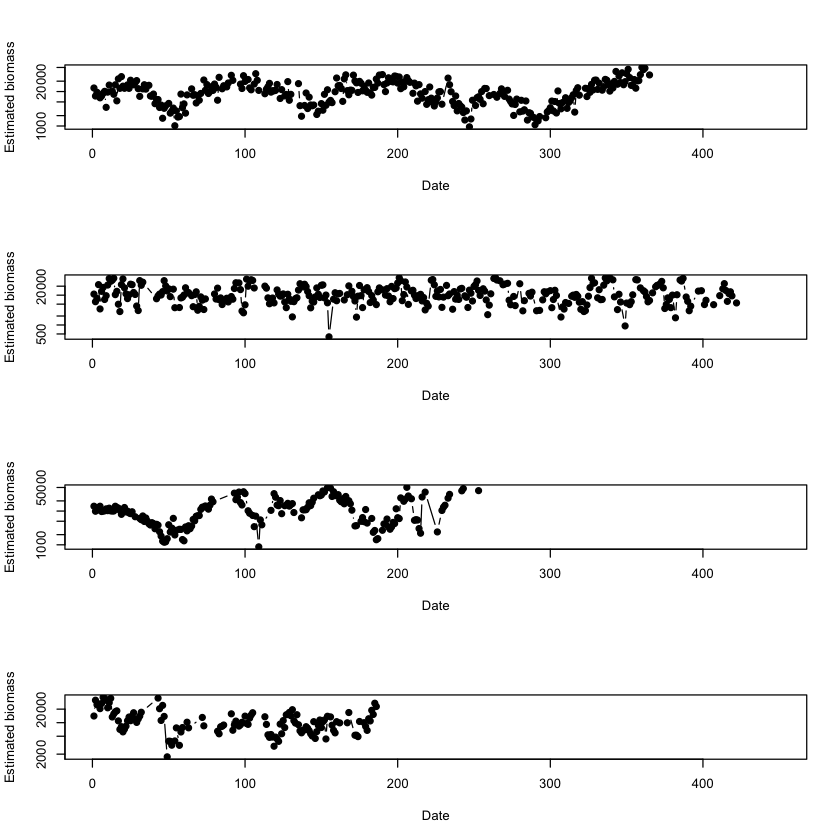

In [13]:
par(mfrow = c(4,1))
plot(x=metadata.da$measurementID,y=getbiomass(res.da), xlim=c(0, 450), type='b', pch=19, xlab='Date', ylab='Estimated biomass', log='y')
plot(x=metadata.m3$measurementID,y=getbiomass(res.m3), xlim=c(0, 450), type='b', pch=19, xlab='Date', ylab='Estimated biomass', log='y')
plot(x=metadata.db$measurementID,y=getbiomass(res.db), xlim=c(0, 450), type='b', pch=19, xlab='Date', ylab='Estimated biomass', log='y')
plot(x=metadata.f4$measurementID,y=getbiomass(res.f4), xlim=c(0, 450), type='b', pch=19, xlab='Date', ylab='Estimated biomass', log='y')

## Plot interaction network

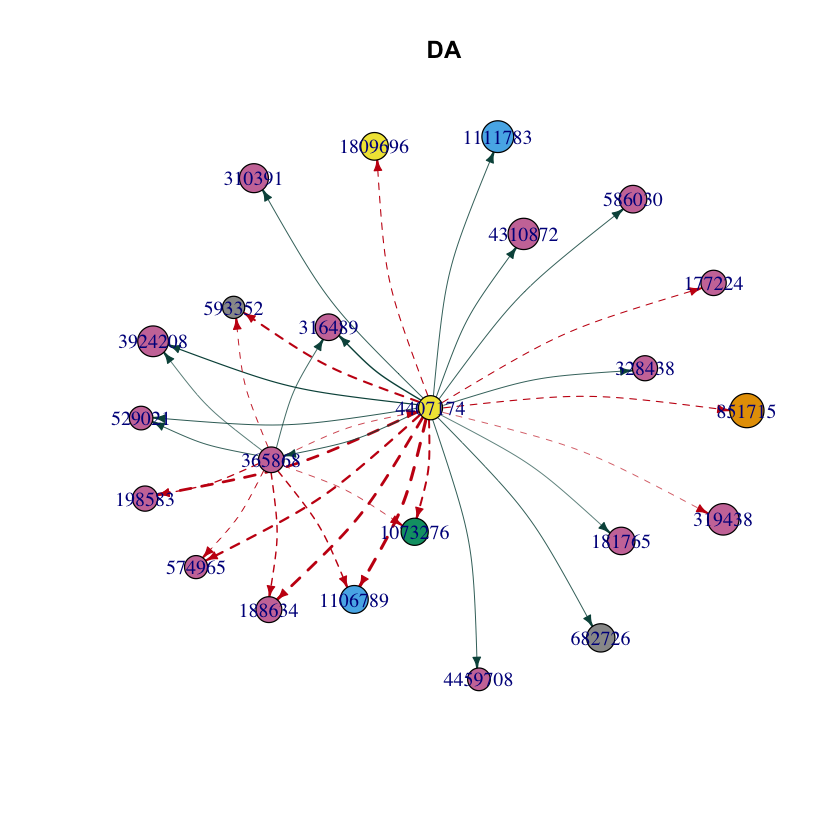

In [19]:
fill_cols <- pal_simpsons(c("springfield"))(16)
ga <- int.net(counts.da, params.da, 1.5, 'DA')

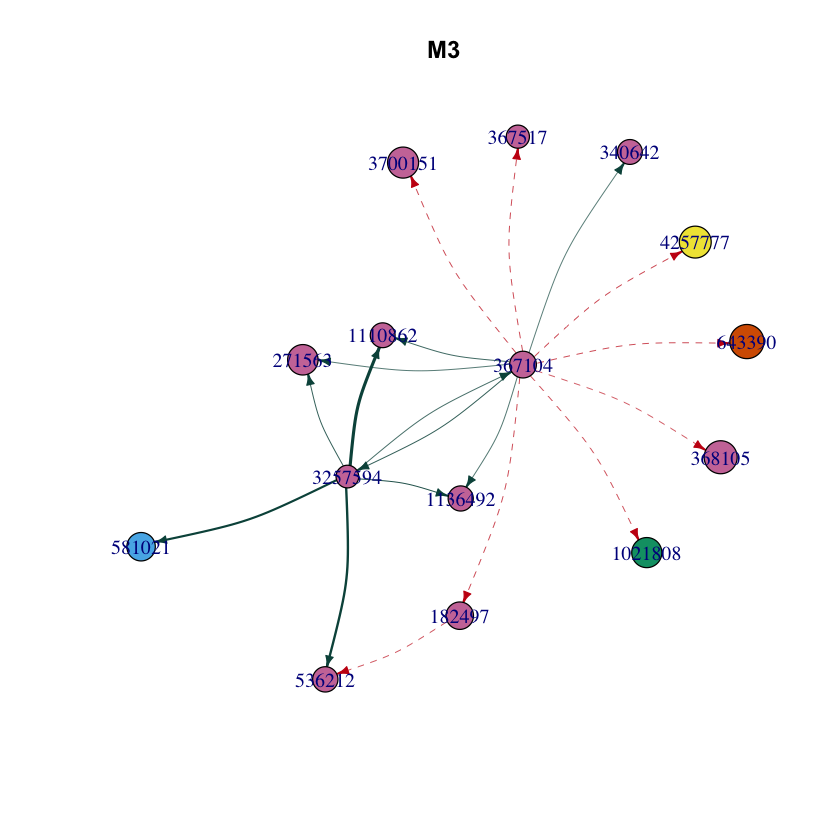

In [20]:
gm <- int.net(counts.m3, params.m3, 1.5, 'M3')

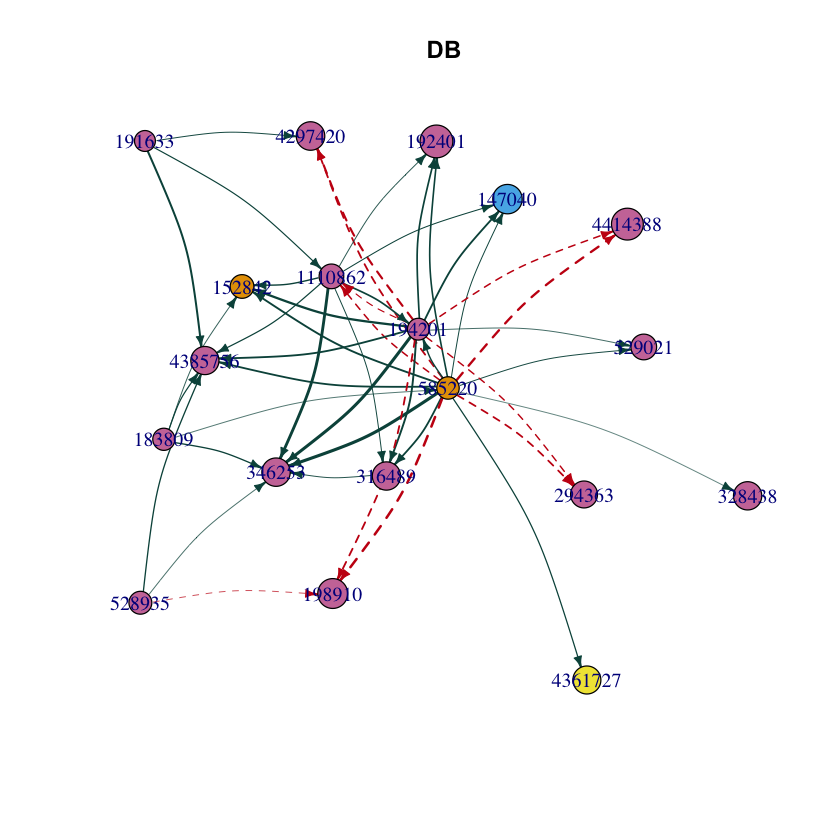

In [21]:
gb <- int.net(counts.db, params.db, 1.5, 'DB')

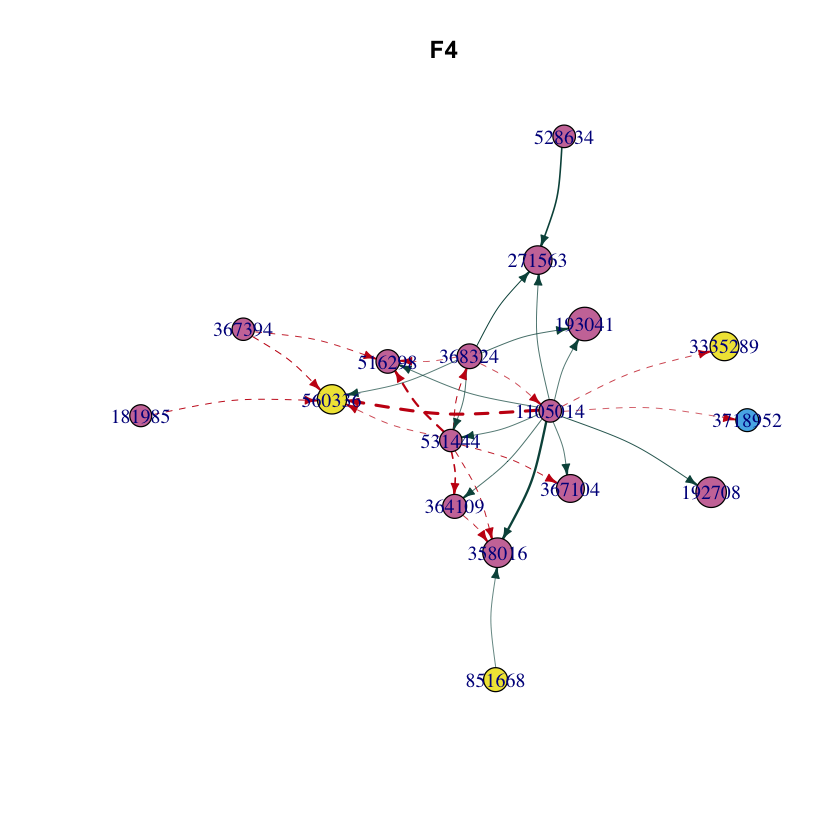

In [22]:
f4 <- int.net(counts.f4, params.f4, 1.5, 'F4')

In [24]:
res.da$counts <- counts.da
res.da$metadata <- metadata.da
saveRDS(res.da, '~/beem/time_series_analysis/DA.EM.rds')
write.table(params.da, '~/beem/time_series_analysis/DA.params.txt', col.names=TRUE, row.names=FALSE, sep='\t', quote=FALSE)

res.m3$counts <- counts.m3
res.m3$metadata <- metadata.m3
saveRDS(res.m3, '~/beem/time_series_analysis/M3.EM.rds')
write.table(params.m3, '~/beem/time_series_analysis/M3.params.txt', col.names=TRUE, row.names=FALSE, sep='\t', quote=FALSE)

res.db$counts <- counts.db
res.db$metadata <- metadata.db
saveRDS(res.db, '~/beem/time_series_analysis/DB.EM.rds')
write.table(params.db, '~/beem/time_series_analysis/DB.params.txt', col.names=TRUE, row.names=FALSE, sep='\t', quote=FALSE)

res.f4$counts <- counts.f4
res.f4$metadata <- metadata.f4
saveRDS(res.f4, '~/beem/time_series_analysis/F4.EM.rds')
write.table(params.f4, '~/beem/time_series_analysis/F4.params.txt', col.names=TRUE, row.names=FALSE, sep='\t', quote=FALSE)